In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_text as text

c:\dev\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# HyperParameters

In [2]:
MAX_TOKENS = 128
BATCH_SIZE = 64
BUFFER_SIZE = 1000
NUM_LAYERS=4
D_MODEL=128
DFF=512
NUM_HEADS=8
EPOCHS = 25


# Data Preprocessing

In [3]:
data , info = tfds.load('ted_hrlr_translate/pt_to_en',with_info=True,as_supervised=True)
train_data, val_data = data["train"],data["validation"]

for pt,en in train_data.batch(1).take(2):
    for example in pt.numpy() :
        print(example.decode("utf-8"))
    for example in en.numpy():
        print(example.decode("utf-8"))  
    print()  

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

mas e se estes fatores fossem ativos ?
but what if it were active ?



## load tokenizer

In [5]:
tokenizers = tf.saved_model.load("tokenizers")
encoded = tokenizers.en.tokenize(en)


for pt,en in train_data.batch(2).take(1):
    print(pt)
    pt = tokenizers.pt.tokenize(pt)
    print(pt)
    pt = pt[:,:MAX_TOKENS]
    print(pt.to_tensor(default_value=0))



tf.Tensor(
[b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
 b'mas e se estes fatores fossem ativos ?'], shape=(2,), dtype=string)
<tf.RaggedTensor [[2, 44, 115, 6402, 148, 40, 887, 14, 3936, 40, 2, 2715, 94, 2, 14, 84, 2,
  40, 117, 1328, 2721, 818, 539, 16, 3]                                   ,
 [2, 99, 44, 89, 199, 2836, 1336, 3996, 32, 3]]>
tf.Tensor(
[[   2   44  115 6402  148   40  887   14 3936   40    2 2715   94    2
    14   84    2   40  117 1328 2721  818  539   16    3]
 [   2   99   44   89  199 2836 1336 3996   32    3    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(2, 25), dtype=int64)


## Build Data pipeline

In [6]:
def load_tensors(pt,en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:,:MAX_TOKENS]
    pt = pt.to_tensor() # PAD when ragged_tensor ==> tensor with 0

    en = tokenizers.en.tokenize(en)
    en = en[:,:MAX_TOKENS+1]
    # we need en_label and en_inputs and that's for teacher_forcing
    en_label = en[:,1:].to_tensor() # remove start
    en = en[:,:-1].to_tensor() #remove end
    return (pt,en),en_label
    


def tfData(ds):
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(load_tensors)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = tfData(train_data)
ds_val = tfData(val_data)

for (pt,en) , label in ds_train.take(4):
    print(en[0][0:5])
    print(label[0][0:5])
    print()
print(label.shape)

tf.Tensor([   2   10  189   11 1084], shape=(5,), dtype=int64)
tf.Tensor([  10  189   11 1084   13], shape=(5,), dtype=int64)

tf.Tensor([   2  198 1912   80   41], shape=(5,), dtype=int64)
tf.Tensor([ 198 1912   80   41 5992], shape=(5,), dtype=int64)

tf.Tensor([   2 2505   27   75    9], shape=(5,), dtype=int64)
tf.Tensor([2505   27   75    9   55], shape=(5,), dtype=int64)

tf.Tensor([  2  78  86 131 207], shape=(5,), dtype=int64)
tf.Tensor([ 78  86 131 207  71], shape=(5,), dtype=int64)

(64, 128)


# Build Model (Transformer)

## Positional Embedding

In [8]:
def positional_encoding(length, depth):
  depth = int(depth / 2)
  pos = np.arange(length).reshape((length,1))
  depth = np.arange(depth).reshape((1,depth))/depth

  power = 1 / (10000**depth)

  z = pos * power

  pos_encoding = np.concatenate([np.sin(z),np.cos(z)],axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape)

(2048, 512)


In [9]:
# class PositionalEmbedding(layers.Layer):
#     def __init__(self,vocab_size,d_model):
#         super(PositionalEmbedding,self).__init__()
#         self.d_model = d_model
#         self.emb=layers.Embedding(vocab_size,d_model,mask_zero=True)
#         self.pos_encoding=positional_encoding(2048,d_model)
#     def call(self,inputs):
#         length = inputs.shape[1]
#         x = self.emb(inputs)
#         x = x*tf.math.sqrt(tf.cast(self.d_model,dtype=tf.float32))
#         x = x + self.pos_encoding[tf.newaxis,:length,:]
        
#         return x
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

embed_pt = PositionalEmbedding(tokenizers.pt.get_vocab_size(),512)
embed_en = PositionalEmbedding(tokenizers.en.get_vocab_size(),512)
pt_em=embed_pt(pt)
en_em=embed_en(en)

print(pt_em.shape)
print(en_em.shape)

(64, 128, 512)
(64, 128, 512)


## Attention


In [10]:
class Attention(layers.Layer):
    def __init__(self,num_heads,key_dim,dropout_rate=0):
        super(Attention,self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,dropout=dropout_rate)
        self.normalizer = layers.LayerNormalization()
        self.add = layers.Add()

# self attention (global)
class SelfAttention(Attention):
    def call(self,inputs,training=False):
        attenion = self.mha(query=inputs,key=inputs,value=inputs,training=training)
        x = self.add([attenion,inputs])
        x = self.normalizer(x)
        return x
    
#cross Attention is the attention layers that connect between encoder and decoder
class CrossAttention(Attention):
    def call(self,context,inputs,training=False):
        attention,attention_scores=self.mha(query=inputs,
                                    key=context
                                    ,value=context
                                    ,return_attention_scores=True
                                    ,training=training)
        
        self.attention_socres = attention_scores
        x = self.add([attention,inputs])
        x = self.normalizer(x)
        return x
    
# Masked Attention for the decoder
class MaskedAttention(Attention):
    def call(self,inputs,training=False):
        attention = self.mha(query=inputs,key=inputs,value=inputs,use_causal_mask=True,training=training)
        x=self.add([attention,inputs])
        x=self.normalizer(x)
        return x

glob=SelfAttention(2,512)
cross=CrossAttention(2,512)
mask=MaskedAttention(2,512)


print(f"glob :{glob(pt_em).shape}")
print(f"cross :{cross(pt_em,en_em).shape}")
print(f"mask :{mask(en_em).shape}")
glob=glob(pt_em)


glob :(64, 128, 512)
cross :(64, 128, 512)
mask :(64, 128, 512)


## Feed Forward

In [11]:
class FeedForward(layers.Layer):
    def __init__(self,d_model,units,dropout_rate=0.1):
        super(FeedForward,self).__init__()
        self.fc1=layers.Dense(units,activation="relu")
        self.fc2=layers.Dense(d_model)
        self.drop=layers.Dropout(dropout_rate)
        self.add=layers.Add()
        self.normalizer = layers.LayerNormalization()
    def call(self,inputs,training=False):
        x = self.fc1(inputs,training=training)
        x = self.fc2(x,training=training)
        x = self.drop(x)
        x = self.add([x,inputs])
        x = self.normalizer(x)
        return x

# ffn = FeedForward(128, 2048)
# print(ffn(glob).shape)

## Encoder

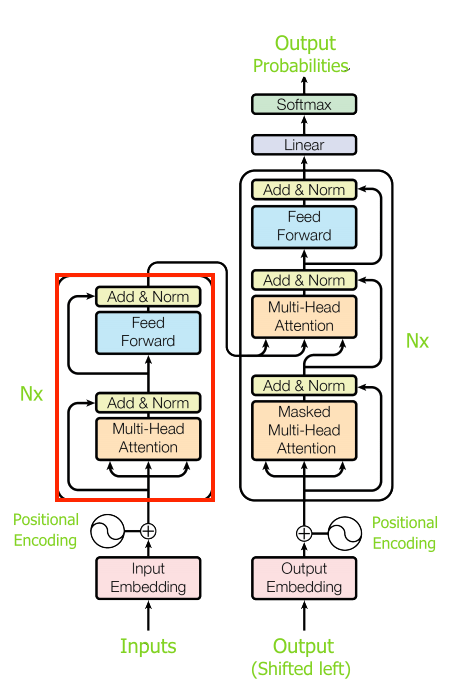

In [12]:
class EncoderLayer(layers.Layer):
    def __init__(self,num_heads,d_model,units,dropout_rate=0.1):
        super(EncoderLayer,self).__init__()
        self.mha=SelfAttention(num_heads,d_model,dropout_rate)
        self.ffn=FeedForward(d_model,units)

    def call(self,inputs,training=False):
        x = self.mha(inputs,training=training)
        x = self.ffn(x,training=training)
        return x
    
encoder_layer = EncoderLayer(d_model=512, num_heads=8,units=2048)
print(encoder_layer(pt_em).shape)

(64, 128, 512)


In [13]:
class Encoder(layers.Layer):
    def __init__(self,num_layers,num_heads,d_model,units,vocab_size,dropout_rate = 0.1):
        super(Encoder,self).__init__()

        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size,d_model)
        self.dropout = layers.Dropout(dropout_rate)

        self.enc_layers = [EncoderLayer(num_heads,d_model,units,dropout_rate) 
                       for _ in range(num_layers)]

    def call(self,inputs,training=False):
        x = self.pos_embedding(inputs)
        x= self.dropout(x,training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training=training)
        
        return x
    

encoder=Encoder(num_layers=4,d_model=512, num_heads=8,units=512,vocab_size=8500)
print(encoder(pt).shape)


        

(64, 128, 512)


## Decoder

In [14]:
class DecoderLayer(layers.Layer):
    def __init__(self,num_heads,d_model,units,dropout_rate=0.1):
        super(DecoderLayer,self).__init__()

        self.mask_mha=MaskedAttention(num_heads=num_heads
                                      ,key_dim=d_model,
                                      dropout_rate=dropout_rate)
        
        self.cross_mha=CrossAttention(num_heads=num_heads,
                                      key_dim=d_model,
                                      dropout_rate=dropout_rate)
        
        self.ffn=FeedForward(d_model,units)
    
    def call(self,context,inputs,training=False):
        x = self.mask_mha(inputs,training=training)
        x = self.cross_mha(context=context,inputs=x,training=training) 

        self.attension_score = self.cross_mha.attention_socres

        x = self.ffn(x,training=training)
        return x

decoder_layer = DecoderLayer(d_model=512, num_heads=8, units=2048)
print(decoder_layer(inputs=en_em,context=pt_em).shape)

(64, 128, 512)


In [15]:
class Decoder(layers.Layer):
    def __init__(self,num_layers,num_heads,d_model,units,vocab_size,dropout_rate=0.1):
        super(Decoder,self).__init__()

        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size,d_model)
        self.dropout=layers.Dropout(dropout_rate)
        
        self.dec_layers = [DecoderLayer(num_heads,d_model,units) 
                       for _ in range(num_layers) ]
    
    def call(self,inputs,context,training=False):
        x = self.pos_embedding(inputs)
        x = self.dropout(x,training=training)
        
        for i in range(self.num_layers):
            x = self.dec_layers[i](inputs=x,context=context,training=training)
        
        self.attention_scores=self.dec_layers[-1].attension_score

        return x

decoder = Decoder(num_layers=4, d_model=512,num_heads=8,units=2048,vocab_size=8000)
print(decoder(inputs=en,context=pt_em).shape)

(64, 128, 512)


## Transformer

In [31]:
class Transfomer(keras.Model):
    def __init__(self,num_layers,d_model,num_heads,units,in_vocab_size,out_vocab_size,dropout_rate):
        super(Transfomer,self).__init__()

        self.encoder=Encoder(num_layers=num_layers,
                             num_heads=num_heads,
                             d_model=d_model,
                             units=units,
                             vocab_size=in_vocab_size,
                             dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers,
                               num_heads=num_heads,
                               d_model=d_model,
                               units=units,
                               vocab_size=out_vocab_size,
                               dropout_rate=dropout_rate)
        
        self.output_layer = layers.Dense(out_vocab_size)

    def call(self,inputs,training=False):
        pt , en = inputs

        context = self.encoder(pt,training=training)
        x = self.decoder(inputs=en,context = context,training=training)

        x = self.output_layer(x)
        return x



In [17]:
transformer=Transfomer(num_layers=NUM_LAYERS,
                       num_heads=NUM_HEADS,
                       units=DFF,
                       d_model=D_MODEL,
                       in_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
                       out_vocab_size=tokenizers.en.get_vocab_size().numpy(),
                       dropout_rate=0.1)

print(en.shape)

output=transformer((pt,en))
print(output.shape)

transformer.summary()

(64, 128)
(64, 128, 7010)
Model: "transfomer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_36 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


# Training

## Custom learning rate & Optimizer

Text(0.5, 1.0, 'Example on learning rate')

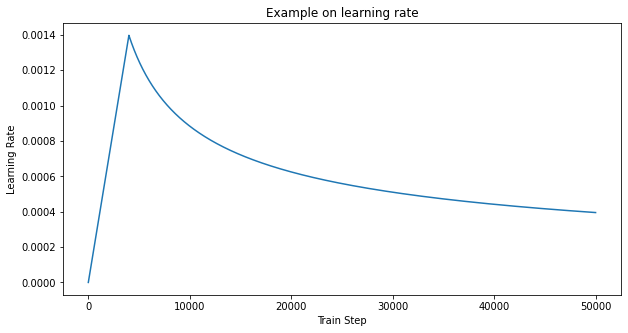

In [ ]:
class CustomLearningrate(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model,warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model,tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self,step):
        step = tf.cast(step,dtype=tf.float32)
        arg1=tf.math.rsqrt(step)
        arg2=step*(self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1,arg2)

learning_rate = CustomLearningrate(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

fig , ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(learning_rate(tf.range(50000, dtype=tf.float32)))
ax.set_ylabel('Learning Rate')
ax.set_xlabel('Train Step')
ax.set_title('Example on learning rate')

## Loss

In [ ]:
def custom_loss(label,pred):
    mask = label != 0
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction="none")
    loss = loss_fn(label,pred)
    mask = tf.cast(mask,loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/ tf.reduce_sum(mask)
    return loss

def custom_accuracy(label, pred):
  
  pred = tf.argmax(pred,axis=2)
  label = tf.cast(label,pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Training

In [ ]:
transformer.compile(optimizer=optimizer,
                    loss=custom_loss,
                    metrics=[custom_accuracy])

In [ ]:
transformer.fit(ds_train,epochs=EPOCHS,validation_data=ds_val)

In [32]:
transformer.load_weights("translator.h5")

In [41]:
start_end = tokenizers.pt.tokenize([''])[0]
start = start_end[0][tf.newaxis]
end = start_end[-1][tf.newaxis]
this = start_end[1][tf.newaxis]

print(start,end,this)

output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
output_array = output_array.write(0, start)
print(output_array.stack())
print(output_array)

tf.Tensor([2], shape=(1,), dtype=int64) tf.Tensor([3], shape=(1,), dtype=int64) tf.Tensor([3], shape=(1,), dtype=int64)
tf.Tensor([[2]], shape=(1, 1), dtype=int64)


In [53]:
class Translator(tf.Module):
      def __init__(self,tokenizers,transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

      def __call__(self,pt):
        pt = self.tokenizers.pt.tokenize(pt)
        pt = pt[:,:MAX_TOKENS]
        pt = pt.to_tensor()

        tokens = self.tokenizers.pt.tokenize([""])[0]
        start = tokens[0][tf.newaxis]
        end = tokens[-1][tf.newaxis]
        english_array = tf.TensorArray(dtype=tf.int64,size=0,dynamic_size=True)
        english_array = english_array.write(0,start)

        for i in range(MAX_TOKENS):
          en=english_array.stack()
          en=tf.transpose(en)
          pred = self.transformer([pt,en],training=False)
          token_id = tf.argmax(pred[:,-1:,:],axis=-1)
          english_array = english_array.write(i+1,token_id[0])
          
          if token_id == end :
            break
          
        en=english_array.stack()
        en=tf.transpose(en)
        text = tokenizers.en.detokenize(en)[0]

        return text
def print_translation(sentence, predicted, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {predicted.numpy()}')
  print(f'{"Ground truth":15s}: {ground_truth}')

translator=Translator(tokenizers,transformer)
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

text = translator([sentence])
text = tf.strings.reduce_join(text, separator=' ', axis=-1)
print_translation(sentence,text,ground_truth)
       

Input:         : este é o primeiro livro que eu fiz.
Prediction     : b'[UNK] so this is the first book that i did . i did .'
Ground truth   : this is the first book i've ever done.
